In [1]:
#Importing required packages.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading dataset
wine = pd.read_csv('C:/Users/86198/Desktop/2022 fall/517/final project/red_wine_normalize.csv')
#wine = pd.read_csv('red_wine_normalized.csv')

In [3]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846,5
1,0.283186,0.520548,0.00,0.116438,0.143573,0.338028,0.215548,0.494126,0.362205,0.209581,0.215385,5
2,0.283186,0.438356,0.04,0.095890,0.133556,0.197183,0.169611,0.508811,0.409449,0.191617,0.215385,5
3,0.584071,0.109589,0.56,0.068493,0.105175,0.225352,0.190813,0.582232,0.330709,0.149701,0.215385,6
4,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846,5


In [4]:
#Information about the data columns
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


# Data Preprocessing for performing Machine learning algorithms¶

In [5]:
#Making binary classificaion for the response variable.
#Dividing wine as good and bad by giving the limit for the quality
bins = (2, 6, 8)
group_names = ['bad', 'good']
wine['quality'] = pd.cut(wine['quality'], bins = bins, labels = group_names)

In [6]:
wine.to_csv('C:/Users/86198/Desktop/2022 fall/517/final project/new_red_wine_normalize.csv')

In [7]:
#Now lets assign a labels to our quality variable
label_quality = LabelEncoder()
#Let Bad wine quality = 0 and good becomes 1 
wine['quality'] = label_quality.fit_transform(wine['quality'])
wine['quality'].value_counts()

0    1382
1     217
Name: quality, dtype: int64

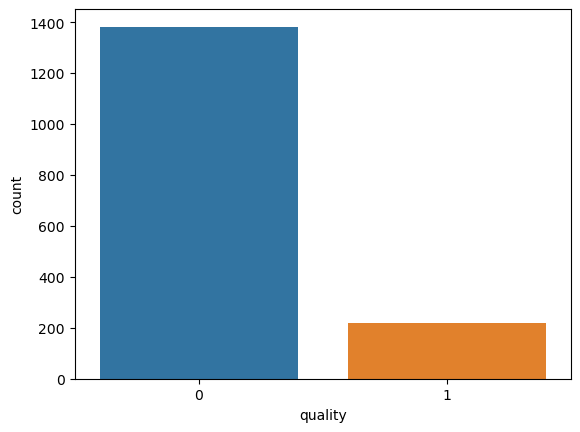

In [8]:
sns.countplot(wine['quality'])

# Feature selection

### 1. Feature selection based on correlation

In [9]:
correlation = wine.corr()

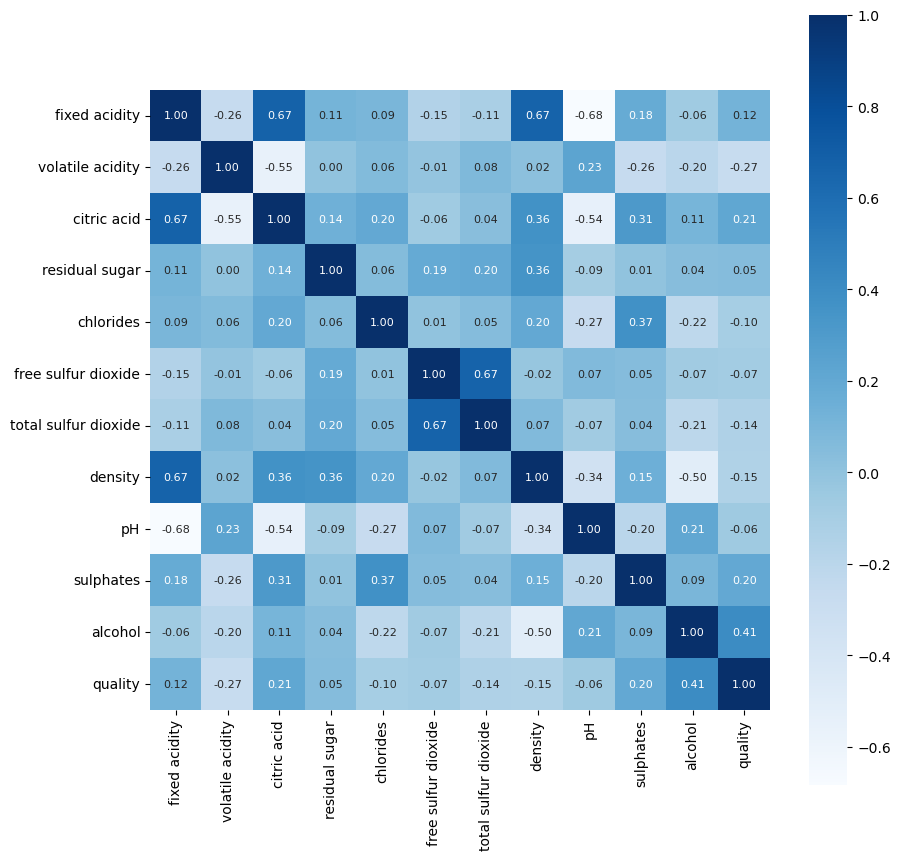

In [10]:
# correlation heatmap
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt = '.2f', annot = True, annot_kws={'size':8}, cmap = 'Blues')

### 2. Feature based on forward and backward selection

In [11]:
X = wine.drop(['quality'], axis = 1)
Y = wine['quality']
feature_names = wine.columns
knn = KNeighborsClassifier()
# set the total number of feature selected
num = 5

In [12]:
#Forward feature selection
sfs_forward = SequentialFeatureSelector(estimator=knn, n_features_to_select=num, direction='forward', 
     scoring='accuracy', cv=5).fit(X,Y)
select_features_list = X.columns[sfs_forward.get_support().tolist()].tolist()
print(
    "Features selected by forward sequential selection: "
    f"{select_features_list}"
)
sfs_forward.transform(X).shape

Features selected by forward sequential selection: ['volatile acidity', 'residual sugar', 'pH', 'sulphates', 'alcohol']


(1599, 5)

In [13]:
#backward feature selection
sfs_backward = SequentialFeatureSelector(estimator=knn, n_features_to_select=num, direction='backward', 
     scoring='accuracy', cv=5).fit(X,Y)
back_select_features_list = X.columns[sfs_backward.get_support().tolist()].tolist()
print(
    "Features selected by backward sequential selection: "
    f"{back_select_features_list}"
)
sfs_backward.transform(X).shape

Features selected by backward sequential selection: ['citric acid', 'residual sugar', 'density', 'sulphates', 'alcohol']


(1599, 5)

### Check the correlation after the feature selection

In [14]:
back_select_features_list

['citric acid', 'residual sugar', 'density', 'sulphates', 'alcohol']

In [15]:
new_column_list = back_select_features_list[:]
new_column_list.append('quality')
new_column_list

['citric acid', 'residual sugar', 'density', 'sulphates', 'alcohol', 'quality']

In [16]:
back_select_features_list

['citric acid', 'residual sugar', 'density', 'sulphates', 'alcohol']

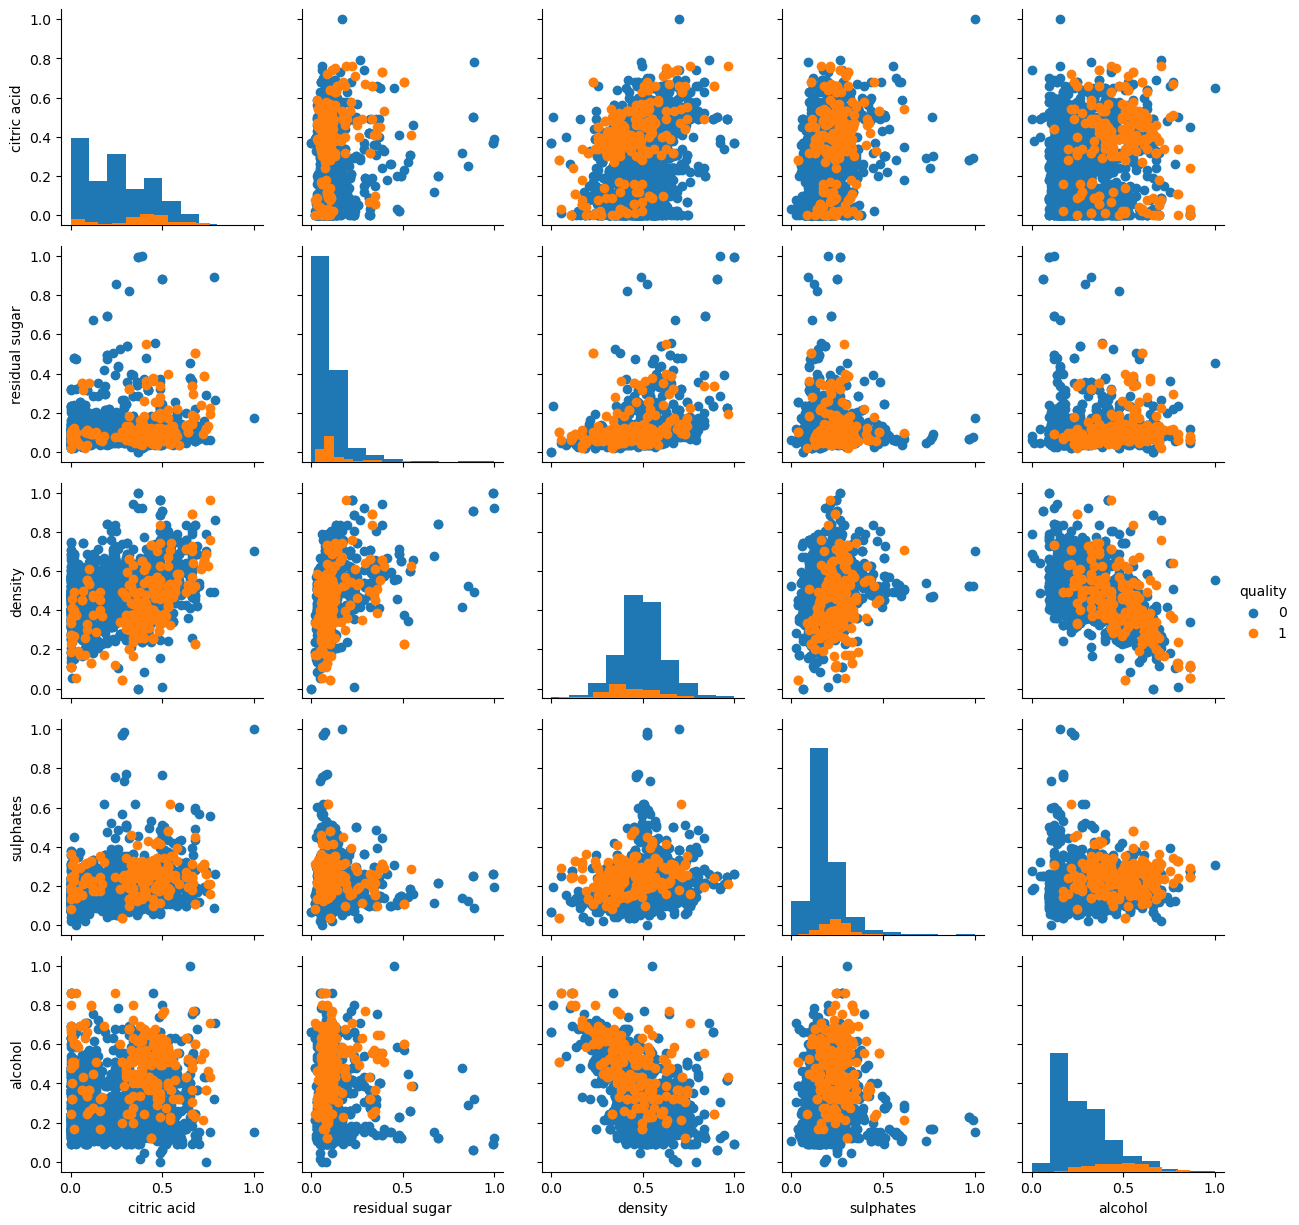

In [17]:
g = sns.PairGrid(wine[new_column_list], hue = 'quality')
g.map_diag(plt.hist);  
g.map_offdiag(plt.scatter);
g.add_legend();

### 3. Construct the training and test data
Here we choose the features selected through Backward selection because it's based on the whole model. 

In [18]:
# Choose train data based on the Backward feature selection
X = wine[select_features_list]
Y = wine['quality']

In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   volatile acidity  1599 non-null   float64
 1   residual sugar    1599 non-null   float64
 2   pH                1599 non-null   float64
 3   sulphates         1599 non-null   float64
 4   alcohol           1599 non-null   float64
dtypes: float64(5)
memory usage: 62.6 KB


In [20]:
#Train and Test splitting of data to 25% testing data, 75% training data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)

# Naive Bayes Classifier

In [21]:
from sklearn.naive_bayes import GaussianNB
#Create classifier
nv = GaussianNB()
#Fit data
nv.fit(X_train,Y_train) 

GaussianNB()

In [22]:
# Predict Y quality from the Naive Bayes Classifier 
# store the prediction data
Y_pred = nv.predict(X_test) 
accuracy_score(Y_test,Y_pred) # calculate the accuracy

0.8625

- Cross-Validation Score

In [23]:
#results = cross_val_score(logistic_regression, X, Y, cv=kfold)
results = cross_val_score(nv, X, Y, cv=5)
print('Cross-Validation Accuracy Scores', results)

Cross-Validation Accuracy Scores [0.865625   0.85625    0.89375    0.809375   0.86833856]


- Confusion Matrix

Accuracy:  0.8625


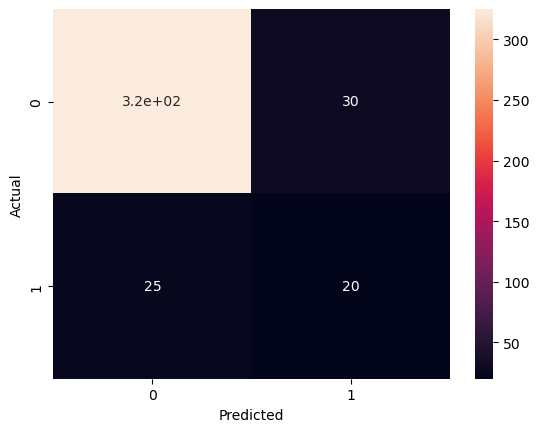

In [24]:
confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

print('Accuracy: ',metrics.accuracy_score(Y_test, Y_pred))
plt.show()

In [25]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       355
           1       0.40      0.44      0.42        45

    accuracy                           0.86       400
   macro avg       0.66      0.68      0.67       400
weighted avg       0.87      0.86      0.87       400



# KNN Classifier

## Determine k value using the error plot for the smallest error(aside from 1, normally we don’t use 1 as the K)

In [26]:
#Determine classifier error rate
error_rate = []
for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, Y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != Y_test))

Text(0, 0.5, 'Error Rate')

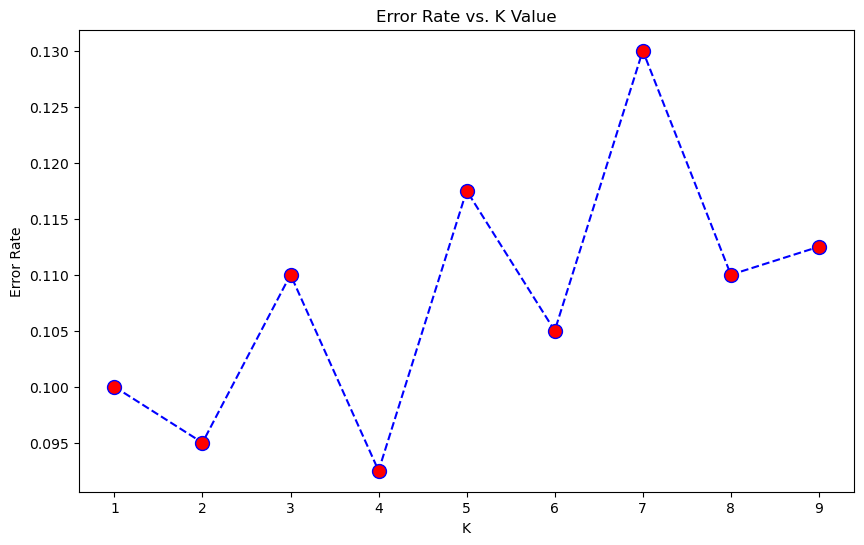

In [27]:
plt.figure(figsize=(10,6))
plt.plot(range(1,10),error_rate,color='blue', linestyle='dashed', marker='o',
markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

The error rate is the smallest when k = 2. Hence we are setting K =2 for the KNN classifier

## Create classifier and set k to 2

In [28]:
knn = KNeighborsClassifier(n_neighbors = 2) 
knn.fit(X_train, Y_train)
Y_pred=knn.predict(X_test)

Accuracy:  0.905


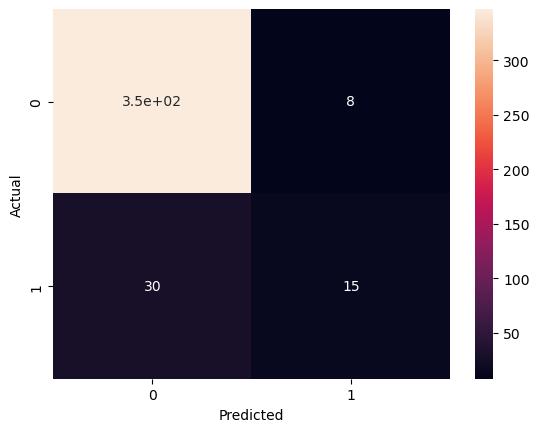

In [29]:
confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

print('Accuracy: ',metrics.accuracy_score(Y_test, Y_pred))
plt.show()

In [30]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       355
           1       0.65      0.33      0.44        45

    accuracy                           0.91       400
   macro avg       0.79      0.66      0.69       400
weighted avg       0.89      0.91      0.89       400



# SVM Classifier

In [31]:
#clf = svm.SVC(kernel="linear", C=1.0)
#clf.fit(X_train, Y_train)
#Y_pred=clf.predict(X_test)

#create a classifier
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)

Accuracy:  0.905


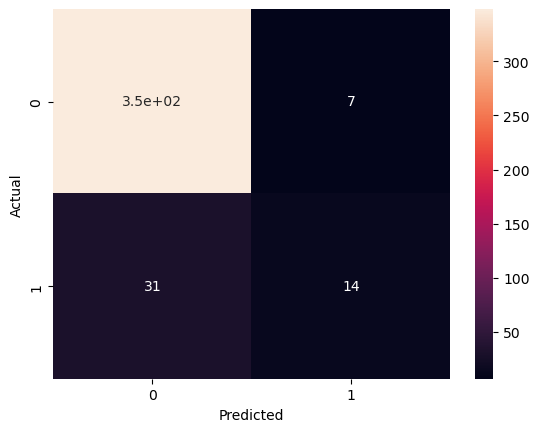

In [32]:
confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

print('Accuracy: ',metrics.accuracy_score(Y_test, Y_pred))
plt.show()

In [33]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       355
           1       0.67      0.31      0.42        45

    accuracy                           0.91       400
   macro avg       0.79      0.65      0.69       400
weighted avg       0.89      0.91      0.89       400

